In [0]:
!ls

## Setting up Colab

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!pip3 install torch torchvision
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pip install tensorboardX
!npm install -g localtunnel

In [0]:
!pip install --no-cache-dir -I pillow

In [1]:
import os
os.chdir("drive/Collab/GANs")
!ls

DCGAN.ipynb  images  logs  Untitled0.ipynb  url.txt  x


In [0]:
import pdb

In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import os
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd.variable import Variable


%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
!mkdir './logs/adam_dc_0.0002_5'

In [0]:
#Tensorboard setup

LOG_DIR = './logs/adam_dc_0.0002_5'


from tensorboardX import SummaryWriter
summary_writer = SummaryWriter(LOG_DIR)


get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)



In [0]:
!rm url.txt

In [0]:

# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')

In [21]:
!cat url.txt

your url is: https://bitter-penguin-73.localtunnel.me
/tools/node/lib/node_modules/localtunnel/bin/client:65
        throw err;
        ^

Error: connection refused: localtunnel.me:46860 (check your firewall settings)
    at Socket.<anonymous> (/tools/node/lib/node_modules/localtunnel/lib/TunnelCluster.js:47:32)
    at emitOne (events.js:116:13)
    at Socket.emit (events.js:211:7)
    at emitErrorNT (internal/streams/destroy.js:64:8)
    at _combinedTickCallback (internal/process/next_tick.js:138:11)
    at process._tickCallback (internal/process/next_tick.js:180:9)
your url is: https://yellow-snail-99.localtunnel.me


### Helper Fxns

In [0]:
def data(dataset):
  dataset = eval('torchvision.datasets.'+dataset)
  transform = transforms.Compose([transforms.Scale(64),
                                 transforms.ToTensor(),
                                 transforms.Normalize((.5,.5,.5),(.5,.5,.5))
                                 ])
  trainset = dataset(root='../data', train=True,download=True, transform=transform)
  print(trainset.train_data.shape)
  imshow(trainset.train_data[0])
  return trainset


In [0]:
def images_to_vectors(images):
  return images.view(images.size(0), 28*28)

def vectors_to_images(vectors):
  return vectors.view(vectors.size(0), 1, 28, 28)

In [0]:
def noise(size):
  n = Variable(torch.randn(size, 100))
  
  if torch.cuda.is_available() : return n.cuda()
  print('not_cuda')
  return n

In [0]:
def denorm(x):
  return (x+1)/2

In [0]:
import torchvision.utils as utils

def load(images, epoch, batch):
  grid = utils.make_grid(images, normalize=True, scale_each=True)
  fig = figure(figsize=(16,16))
  imshow(np.moveaxis(grid.numpy(), 0, -1))
  axis('off')
  fig.savefig('images/epoch_{}_batch_{}.png'.format(epoch, batch))
  
  return grid

def log(g_error, d_error, steps):
  summary_writer.add_scalar('generator_error', float(g_error), steps)
  summary_writer.add_scalar('discriminator_error', float(d_error), steps)
  return None

### Load Data

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


torch.Size([60000, 28, 28])
60000


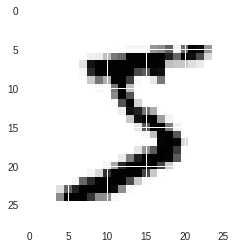

In [27]:
dset = data('MNIST')
sample_size = dset.train_data.size(0)
print(sample_size)

In [0]:

batch_size = 256
dataloader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=True)


### Discriminator

In [0]:
class Discriminator(nn.Module):
  """
  Discriminative Network
  """
  def __init__(self):
    super().__init__()
    df = 64
    self.network = nn.Sequential(
        
        nn.Conv2d(1, df, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
         
        self.conv(df, df*2),
        self.conv(df*2,df*4),
        self.conv(df*4, df*8),

        nn.Conv2d(df*8, 1, 4, 1,0),
        nn.Sigmoid(),
        )
    
    
    
  def conv(self, in_, out_): return nn.Sequential(nn.Conv2d(in_, out_, 4, 2, 1, bias=False), nn.BatchNorm2d(out_), nn.LeakyReLU(0.2, inplace=True)) 
  
  def forward(self, x): 
 
    return self.network(x)

In [30]:
print(Discriminator())

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), str

### Generator

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    gf = 64
    
    self.network = nn.Sequential(
        
        self.deconv(100, gf*8,stride=1, pad=0),
        self.deconv(gf*8,gf*4),
        self.deconv(gf*4,gf*2),
        self.deconv(gf*2, gf),
        nn.ConvTranspose2d(gf,1,4,2,1)
        )
    
  def deconv(self, in_, out_,stride=2,pad=1):return nn.Sequential(nn.ConvTranspose2d(in_,out_, 4, stride, pad, bias=False), nn.BatchNorm2d(out_), nn.LeakyReLU(0.2, inplace=True))
  
  def forward(self, x): return torch.tanh(self.network(x))

In [32]:
print(Generator())

Generator(
  (network): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [0]:
def init_weights(m):
  classname= m.__class__.__name__
  if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
    m.weight.data.normal_(0.00, 0.02)

In [0]:
discriminator = Discriminator()
discriminator.apply(init_weights)

generator = Generator()
generator.apply(init_weights)

if torch.cuda.is_available():
  discriminator.cuda()
  generator.cuda()

### Optimization

In [0]:
d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

loss = nn.BCELoss()

num_epochs = 200

### Training

In [0]:
# Preparing Targets:
def real_data_targets(size):
  data = Variable(torch.ones(size,1))
  if torch.cuda.is_available():return data.cuda()
  return data

def fake_data_targets(size):
  data = Variable(torch.zeros(size, 1))
  if torch.cuda.is_available(): return data.cuda()
  return data


In [0]:
def train_discriminator(optimizer, real_data, fake_data):
  optimizer.zero_grad()
  
  prediction_real = discriminator(real_data)
  error_real = loss(prediction_real, real_data_targets(real_data.size(0)))
  error_real.backward(retain_graph=True)

  
  prediction_fake = discriminator(fake_data)
  prediction_fake = prediction_fake.squeeze()
  error_fake = loss(prediction_fake,fake_data_targets(real_data.size(0)).squeeze())
  error_fake.backward(retain_graph=True)
  
  optimizer.step()
  
  return error_real+error_fake, prediction_real, prediction_fake


def train_generator(optimizer, fake_data):
  optimizer.zero_grad()
  
  prediction = discriminator(fake_data)
  error = loss(prediction, real_data_targets(prediction.size(0)))
  error.backward()
  
  optimizer.step()
  return error


In [0]:
## Generating Display Samples
num_samples = 16
test_noise = noise(num_samples).view(-1,100,1,1)


In [0]:
epochs = 200
counter = 0
for epoch in range(epochs):
  for i, (batch,_) in enumerate(dataloader):
    steps = epoch*((sample_size//batch_size)+1 if sample_size%batch_size == 0 else sample_size//batch_size)+i
    
    # Train the Discriminator
    
    real_data = Variable(batch)
    real_data = real_data.cuda() if torch.cuda.is_available() else real_data
    
    generated = noise(real_data.size(0)).view(-1,100,1,1)
    fake_data = generator(generated).detach()
    d_error, d_pred_real, d_pred_fake = train_discriminator(d, real_data, fake_data)
    
    # Train the Generator once every five times Disc is trained
    if steps > 10 or steps ==0:
      fake_data = generator(noise(real_data.size(0)).view(-1,100,1,1))
      g_error = train_generator(g, fake_data)
    
    counter+=1
    # logging
    jack = [g_error.data.cpu().numpy(), d_error.data.cpu().numpy(), steps]
    print(*jack)
    
    log(*jack)
    
    if i%100 == 1:

      test_images = generator(test_noise).data.cpu()
      grid = load(denorm(test_images), epoch, i)
      summary_writer.add_image('Zilla',grid, steps)
      
    

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([256, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0.71442735 1.3949764 0
0.71442735 1.3354183 1
0.71442735 1.2685527 2
0.71442735 1.1985043 3
0.71442735 1.1181955 4
0.71442735 1.0396161 5
0.71442735 0.96226513 6
0.71442735 0.8836333 7
0.71442735 0.8155056 8
0.71442735 0.75293905 9
0.71442735 0.69732296 10
1.3642864 0.649752 11
1.3993698 0.6123686 12
1.4331808 0.5856078 13
1.4657809 0.56646407 14
1.499092 0.5544087 15
1.5366162 0.5584654 16
1.5872055 0.55035084 17
1.6530224 0.50428677 18
1.7113553 0.45835 19
1.7673525 0.41581717 20
1.8297619 0.38423115 21
1.8850468 0.35221487 22
1.9364952 0.3297953 23
1.9890653 0.30906895 24
2.0432422 0.29076898 25
2.0857782 0.27200764 26
2.1328354 0.25811875 27
2.1763284 0.24523461 28
2.2156088 0.2309416 29
2.2515361 0.2212797 30
2.2819905 0.2114105 31
2.3027925 0.2059724 32
2.3545651 0.2013451 33
2.3928602 0.18737608 34
2.4175856 0.17910787 35
2.4513996 0.17224881 36
2.468483 0.16646263 37
2.4859936 0.16020122 38
2.504535 0.15811548 39
2.5311856 0.15307724 40
2.5744076 0.1483303 41
2.6244612 0.140347

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([96, 1])) that is different to the input size (torch.Size([96, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


5.7893977 0.0055259764 234
5.782296 0.0054330034 234
5.7858634 0.0054195253 235
5.7958837 0.005384391 236
5.790889 0.0053468375 237
5.7997384 0.005325529 238
5.8070774 0.0053133513 239
5.815937 0.0052636117 240
5.8130636 0.005183491 241
5.8222156 0.0051929615 242
5.822734 0.0051629283 243
5.8180685 0.005174603 244
5.8324795 0.005194621 245
5.816351 0.0052242894 246
5.8296933 0.005260188 247
5.827604 0.0052710166 248
5.8466372 0.0050831987 249
5.857597 0.0049988646 250
5.864839 0.004962294 251
5.87 0.0049508815 252
5.879344 0.0048847403 253
5.8913302 0.0048056142 254
5.9018893 0.0047923056 255
5.9017267 0.0047528 256
5.9163957 0.0047202716 257
5.9167137 0.0046363333 258
5.9248214 0.0046985717 259
5.9262953 0.004731074 260
5.91776 0.0048828977 261
5.894562 0.0048936345 262
5.927639 0.00461537 263
5.9668303 0.0045891562 264
5.9810123 0.004462798 265
6.0045443 0.004381745 266
6.001011 0.004350109 267
6.012227 0.004324267 268
6.007306 0.0042655943 269
6.026977 0.0042364937 270
6.02501 0.004

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2.9137888 0.44133002 1606
1.1088637 0.44817495 1607
4.331402 0.6590993 1608
0.71562415 1.375518 1609
3.3735926 1.0759027 1610
1.1151052 1.2158543 1611
2.3796968 0.75172114 1612
2.4820905 0.49233964 1613
1.7057546 0.52712446 1614
2.5103307 0.5469635 1615
2.297702 0.4192298 1616
2.4878438 0.41037214 1617
2.054296 0.43203145 1618
3.1304655 0.3698711 1619
1.802025 0.44857603 1620
3.191404 0.42623362 1621
2.2488499 0.3383297 1622
2.1108425 0.33314368 1623
3.2250848 0.30938926 1624
1.1330442 0.4318038 1625
4.7323394 0.7086412 1626
1.4128219 1.1142327 1627
2.3443441 0.48195177 1628
2.5403328 0.4891103 1629
1.8125523 0.4931146 1630
3.8362908 0.59575146 1631
1.0089468 1.1000626 1632
4.4768195 0.898444 1633
1.2960691 1.365057 1634
2.9857445 0.66645545 1635
2.594555 0.4593965 1636
1.7419744 0.43827096 1637
3.4186852 0.528949 1638
1.0682306 0.70832765 1638
2.93671 0.8440138 1639
2.2958326 0.71010673 1640
2.3636265 0.61026025 1641
2.9525747 0.321786 1642
2.369308 0.30782002 1643
2.5962658 0.3424272

In [0]:
# %debug